We are developing an automated language scorer which will be able to able to predict a score by analyzing text essays content.

Given a dataset of essays and their corresponding scores on the scale of 1-5, we are going to fine-tune a small Transformer model using PyTorch that can accurately predict the score of an essay.
 
### Environment
- For this coding test a 2-core CPU and 16GB of RAM is available
- Git is available to version files, any part of the code given can be modified
- Any other external tool can be used for this test
- Expect to take 2 to 3 hours to complete these exercise
- There is a 6 hours time limit for your submission

### Files and folders
- `train.csv`, the training dataset
- `test.csv`, the testing dataset
- `bert-tiny`, the pre-trained model to fine-tune and its related files
- `sample-submissions.csv`, an example of how your `submissions.csv` file should be formatted
 
### Deliverables

1. 'submissions.csv': For each record in the test set `test.csv`, predict the value of the 'score' variable. Submit a CSV file with a header row and one row per test entry. The file `submissions.csv` should have exactly 2 columns:
content and score (1 -5).

> The model will be tested on a different set of essays from the training set.

2. Well commented Jupyter notebook including cell outputs and answers to Questions 1-3.

> Annotate the notebook with code comments and markdowns. A person should be able to read the notebook and understand the steps taken as well as the reasoning behind them.


In [21]:
# Install libraries
# ! pip3 install transformers==4.26.0 torch pandas datasets

# Download base model
! wget -P bert-tiny/ https://hr-projects-assets-prod.s3.amazonaws.com/6cj60qp1cd9/97ebab92d945fd74ec334ec7d7aecac0/pytorch_model.bin

# Ignore model folder in git
! echo "bert-tiny/" >> .gitignore

# To install packages that are not installed by default, uncomment the next line
# and replace <package list> with a list of needed packages.

#! pip3 install <package list>

--2025-03-28 15:22:27--  https://hr-projects-assets-prod.s3.amazonaws.com/6cj60qp1cd9/97ebab92d945fd74ec334ec7d7aecac0/pytorch_model.bin
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 52.217.234.217, 52.216.54.193, 3.5.28.69, ...
Connecting to hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)|52.217.234.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17756393 (17M) [binary/octet-stream]
Saving to: ‘bert-tiny/pytorch_model.bin’

pytorch_model.bin   100%[===================>]  16.93M  3.30MB/s    in 5.2s    

2025-03-28 15:22:36 (3.29 MB/s) - ‘bert-tiny/pytorch_model.bin’ saved [17756393/17756393]



# Get Bert tokenizer

We need to work with numerical data. We will use the Bert tokenizer to convert the text data into numerical data.
The word tokenizer splits text into individual words. The Bert tokenizer splits text into subwords. 
    
- This is useful because Bert has a fixed vocabulary size. If a word is not in the vocabulary, it is split into subwords that are in the vocabulary.
- The data contains @CAPS1 @PERSON - these are special tokens that Bert uses to represent capitalization and named entities. We will need to remove these tokens before tokenizing the data. 
    - Not sure if the data I was given contains these tokens?  These are used for privacy, consistency and to reduce the vocabulary size. Also avoids overfitting to surface level-lexical cues.

In [115]:
from transformers import BertTokenizer, AutoTokenizer

# download bert tokenizer and store it in the bert-tiny folder
# BertTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2").save_pretrained(
#     "bert-tiny"
# )
# tokeniser = BertTokenizer.from_pretrained("bert-tiny", local_files_only=True)

tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-uncased"
)  # or the one you're actually using

In [1]:
# Load libraries, add more as required
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

/Users/matt/work/fine-tuning/venv-11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Score Distribution:
 score
1     15
2    154
3    702
4    845
Name: count, dtype: int64


(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

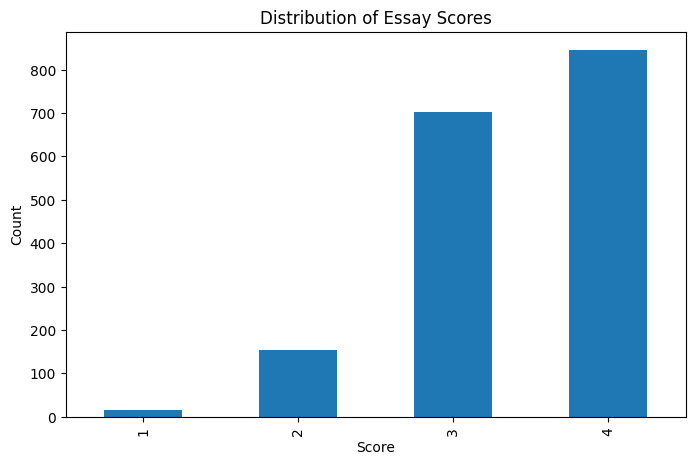

In [3]:
import matplotlib.pyplot as plt

train_df = pd.read_csv("data/cleaned_dataset.csv")
score_counts = train_df["score"].value_counts().sort_index()

print("Score Distribution:\n", score_counts)

plt.figure(figsize=(8, 5))
score_counts.plot(kind="bar")
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Distribution of Essay Scores")
plt.xticks()

# Explore the data

In [5]:
# train_df.iloc[0]
# drop index
# train_df = train_df.drop(columns=["Unnamed: 0"])
train_df
# keep only content and score
train_df = train_df[["content", "score"]]
train_df

,content,score
0,Certain materials being removed from libraries...,4
1,Write a persuasive essay to a newspaper reflec...,1
2,Do you think that libraries should remove cert...,3
3,"In @DATE1's world, there are many things found...",4
4,In life you have the 'offensive things'. The l...,4
...,...,...
1711,Libraries have a variety of material from book...,3
1712,"I do not think that materials, such as books, ...",3
1713,"Yes we should keep the books,music,movies,an m...",2
1714,"I do believe that book, magazines, music, mov...",4


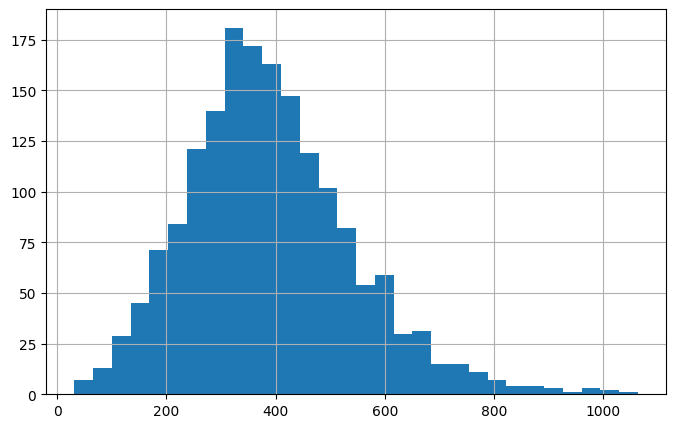

In [4]:
# distribution of essay lengths
train_df["text_length"] = train_df["content"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
train_df["text_length"].hist(bins=30)
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


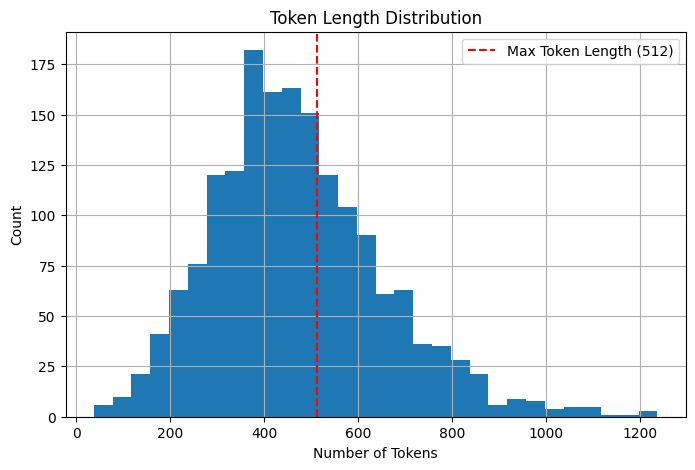

In [114]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Load a tokenizer (e.g., from a model you used)
tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-uncased"
)  # or the one you're actually using

# Compute token lengths
train_df["token_length"] = train_df["content"].apply(
    lambda x: len(tokenizer.encode(str(x), truncation=False))
)

# Plot distribution
plt.figure(figsize=(8, 5))
train_df["token_length"].hist(bins=30)
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.axvline(512, color="red", linestyle="--", label="Max Token Length (512)")
plt.legend()
plt.show()

Q1. Will a model with a maximum sequence of 512 tokens be useful?

Yes, but a few caveats. Some essays exceed the 512 token limit. There will be some truncation - long essays - of which there are only a few, will affect model performance as some information is lost. One approach is to split long essays into overlapping chunks and then process each separately - we can then make multiple predictions per essay and then average. It's also useful to bear in mind that BERT tokenization does not correspond to word count. 1 word can be split up into multiple tokens (1.3+). 

Question 2. Divide the training dataset in 80% used for training and 20% for validation. Train a neural network, that can predict the score of the essays. It needs to be based on BERT-tiny and fine-tuned with the available dataset contained in train.csv. Show that your model accuracy on the validation part of the dataset is 75% or more. Training can take a few minutes, we recommend using a single epoch. 

Suggested steps:
- Create two PyTorch DataLoaders, training and validation from train.csv
- Load the base model for training
- Train for a single epoch (this computation takes about 15 minutes)
- Check that predictions on validation dataset are sensible
- Save fine-tuned model including optimizer states.

Code for loading the dataset in a DataFrame and the tokenizer and model is given below.

# Define Dataset classes for training and validation

In [ ]:
import torch
from typing import Dict, Any, Tuple
from torch import Tensor
from torch.utils.data import Dataset, random_split
from transformers import BertTokenizer


# create a dataset class that inherits from torch.Dataset
class EssayDataset(Dataset):
    """
    Dataset class for handing training and test data.
    TODO: Generalise to handle validation split as well.


    """

    def __init__(
        self,
        df: pd.DataFrame,
        tokeniser: BertTokenizer,
        target_label=None,
        max_length: int = 512,
    ):
        """
        Args:
        df (pd.DataFrame): Dataframe of train or test dataset.
        tokeniser (BertTokenizer): Pre-trained tokenizer
        target_label (string) : The label corresponding to our scores.
        max_length(int, optional):
        """
        self.data = df
        self.tokenizer = tokeniser
        self.max_length = max_length
        self.target_label = target_label

    def __len__(self) -> int:
        """
        Returns the number of samples.
        To iterate over it it needs to know its length.
        Torch automatically shuffles the dataset after we've visited all samples.
        Therefore it needs to know its length.
        """
        return len(self.data)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        """
        Tokenises the essay and returns input or input+label depending on
        whether self.target_label is None.

        Returns:
            data_dict (Dict[str, Tensor]): Dictionary of tokenised essay, attention_mask and score

        """

        # performance implications of this?

        essay = str(self.data.iloc[index]["content"])  # get essay text
        # score = int(self.data.iloc[index]["score"]) - 1 # convert to 0-based index

        encoding = self.tokenizer(
            essay,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        data_dict = {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
        }

        # this generalises the EssayDataset class to work with test data as well
        # we also need to check that the target_label is indeed "score"
        # obviously this could be generalised further.
        if self.target_label is not None:
            # convert to 0-based index
            data_dict["score"] = torch.tensor(int(self.data.iloc[index]["score"]) - 1)

        return data_dict


def split_essay_data(full_dataset: Dataset) -> Tuple[Dataset, Dataset]:
    """
    Split essay data for to check performance on held out validation set.
    This sits outside the EssayDataset class as it is a utility function.
    Separation of concerns. It decoupled from the Dataset class, it allows
    us to test other strategies for splitting the data.

    This also relies on knowing the length of the dataset.

    Args:
        full_dataset (Dataset): The full dataset that we intend to split.

    Returns:
        train_dataset (Dataset):
        val_dataset (Dataset):

    """
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    # set manual seed to ensure reproducibility
    torch.manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    return train_dataset, val_dataset

# Test dataset objects

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_df = pd.read_csv("data/cleaned_dataset.csv")
dataset = EssayDataset(train_df, tokenizer)

In [124]:
type(dataset)
for i in iter(dataset):
    # print(i)
    pass

dataset isn't an iterable unless you explicitly call iter on it or use a DataLoader. Dataset class needs to implement `__iter__` if so. 

# Create datasets and train, val data loaders

In [64]:
import pandas as pd
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification

tokeniser = BertTokenizer.from_pretrained("bert-tiny")
model = BertForSequenceClassification.from_pretrained("bert-tiny", num_labels=4)

train_df = pd.read_csv("data/cleaned_dataset.csv")

full_dataset = EssayDataset(train_df, tokeniser, target_label="score")

train_dataset, val_dataset = split_essay_data(full_dataset)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Some weights of the model checkpoint at bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from

# Testing datasets and dataloaders

In [59]:
#  test EssayDataset - TODO: provide a robust set of tests here.

# test __getitem__
print(train_dataset[0])

# train_df.iloc[0] # -> []

# print(train_df.iloc[0])
# test __len__
# print(len(full_dataset))

# print("train dataset length ", len(train_dataset))
# print("val dataset length ", len(val_dataset))

{'input_ids': tensor([  101,  1045,  2064,  2228,  1997,  2195,  2808,  2008,  1010,  1045,
         2052,  2025,  2215,  1037,  2775,  1997,  3067,  2000,  4060,  2039,
         1998,  3191,  1012,  1045,  2004,  2574,  2004,  1045,  2464,  2054,
         1045,  2001,  2183,  2000,  2022,  3015,  2055,  2023,  2028,  8373,
         1999,  2026,  2132,  2066,  7497,  1012,  1996,  2338,  2008,  1030,
         9700,  2487, 10549,  2003,  2170,  1005,  1030,  9700,  2475,  1030,
         9700,  2509,  1030,  9700,  2549,  1012,  1005,  1996,  2338,  1005,
         1030,  9700,  2475,  1030,  9700,  2509,  1030,  9700,  2549,  1005,
         2003,  2055,  1037,  2402,  2611,  2008,  3473,  2039,  2302,  1037,
         2269,  1012,  2014,  2388,  2196,  2359,  2000,  2831,  2055,  2032,
         2138,  1010,  2016,  2354,  2008,  2023,  2126,  2069,  2183,  2000,
         2191,  5609,  4788,  1012,  1996,  2402,  2611,  3473,  2039,  2007,
         1996,  3959,  1997,  2108,  8600,  1005, 

In [9]:
model = BertForSequenceClassification.from_pretrained(
    "bert-tiny", local_files_only=True, num_labels=4
)

Some weights of the model checkpoint at bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from

In [ ]:
from torch import Tensor
from torch.nn import CrossEntropyLoss, Module
from torch.utils.data import DataLoader
from torch.optim import Optimizer, AdamW
from numpy import mean, unique


def get_accuracy(preds, labels):
    """
    TODO: docstrings
    """
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total


def evaluate_model(
    model: Module, val_loader: DataLoader, loss_fn: CrossEntropyLoss
) -> Dict[str, float]:
    """
    TODO: docstrings
    """
    # Put model in evaluation mode. So we do not drink statistics from validation set. (Take statistics from training
    # uses running stats instead of batch stats. Also turns off dropout layers.
    model.eval()

    # add to metrics dictionary
    metrics = {"loss": [], "accuracy": []}

    # no need to store gradients
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"]

            attention_mask = batch["attention_mask"]

            labels = batch["score"]

            outputs = model(input_ids, attention_mask=attention_mask)
            # outputs.logits is the raw output of the model. It has shape (batch_size, num_labels)

            loss = loss_fn(outputs.logits, labels)

            # accumulate total loss over entire batch
            preds = torch.argmax(outputs.logits, dim=1)  # (batch_size,)

            # add to metrics dictionary
            metrics["loss"].append(loss.item())
            metrics["accuracy"].append(get_accuracy(preds, labels))

    # dictionary comprehension to get mean of each metric
    return {key: mean(val) for key, val in metrics.items()}


# could also use BCELoss - convert to one-hot encoding?
def train_model(
    model: Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimiser: Optimizer,
    loss_fn: CrossEntropyLoss,
    epochs: int = 1,
) -> Module:
    """
    TODO: Improve docstrings. This is just a skeleton.

    Train a model on essay text with scores as labels.

    Args:
        model (Module) :
        train_loader (DataLoader) :
        val_loader (DataLoader) : (UNUSED) - this would be used here if we trained for multiple epochs.
        optimiser (Optimiser) :
        loss_fn (CrossEntropyLoss) :
        epochs (int) :

    Returns:
        Trained model

    """
    # Prepare model for training. This turns certain layers on and tells batch
    # norm layers to use incoming statistics and let the contribute to their memory.

    metrics = {"loss": [], "accuracy": []}

    # for illustration only (we only train on one epoch).
    for epoch in range(epochs):
        model.train()
        for iter, batch in enumerate(train_loader):
            # zero the gradients (otherwise gradients accumulate)
            optimiser.zero_grad()

            input_ids = batch["input_ids"]
            # the attention mask tells us which tokens are real words and which are padding.

            attention_mask = batch["attention_mask"]
            labels = batch["score"]

            outputs = model(input_ids, attention_mask=attention_mask)

            # compute loss
            # outputs.logits is the raw output of the model. It has shape (batch_size, num_labels)
            # labels is the true label of the data. It has shape (batch_size)
            # internally CE loss does the following:
            # loss = -log(softmax(logits)[label])
            loss = loss_fn(outputs.logits, labels)

            # compute gradients
            loss.backward()

            # nudge parameters in direction of steepest descent
            optimiser.step()

            # compute accuracy on batch basis
            preds = torch.argmax(outputs.logits, dim=1)

            # loss is tensor - get value using item()
            metrics["loss"].append(loss.item())
            metrics["accuracy"].append(get_accuracy(preds, labels))

            # debugging
            # print(iter, metrics["accuracy"][-1], loss.item())
            # visualise every 10 steps (10 * batch_size) = 160 samples per print.
            if iter % 10 == 0:
                print("step: ", iter, ", batch loss: ", loss.item())

        val_metrics = evaluate_model(model, val_loader, loss_fn)
        print(
            f"Validation — Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}"
        )

    # just output train averages for now - we'll get validation loss / accuracy next.
    print("Train averages ", {key: mean(val) for key, val in metrics.items()})

    # return fine-tuned model
    return model

# Define model and call train loop

In [ ]:
# main loop
# we treat this as a very simple classification task - even though we could potentially make use of ordinality in loss function.
model = BertForSequenceClassification.from_pretrained(
    "bert-tiny", local_files_only=True, num_labels=4
)
optimiser: Optimizer = AdamW(model.parameters(), lr=1e-4)

# apply some

from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get full list of labels from the training dataset
# train_labels = train_dataset.data["score"].astype(int) - 1

# train_indices = train_dataset.indices
# train_labels = full_dataset.data.iloc[train_indices]["score"].astype(int) - 1
# train_labels = train_labels.astype(int).to_numpy()

# class_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=np.array([0, 1, 2, 3]),
#     y=train_labels
# )
# weights = torch.tensor(class_weights, dtype=torch.float32)

# Define loss function with weights
# loss_fn = CrossEntropyLoss(weight=weights)
loss_fn = CrossEntropyLoss(weight=weights)

model = train_model(model, train_loader, val_loader, optimiser, loss_fn, epochs=4)
model.save_pretrained("bert_tiny_finetuned")

# save the optimiser state as well
torch.save(optimiser.state_dict(), "optimiser-fine.pth")

Some weights of the model checkpoint at bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from

step:  0 , batch loss:  1.446410894393921
step:  10 , batch loss:  1.2305426597595215
step:  20 , batch loss:  1.3522636890411377
step:  30 , batch loss:  1.381296157836914
step:  40 , batch loss:  1.6971291303634644
step:  50 , batch loss:  1.232558012008667
step:  60 , batch loss:  1.2458539009094238
step:  70 , batch loss:  1.2924011945724487
step:  80 , batch loss:  1.3865528106689453
step:  0 , batch loss:  1.1215143203735352
step:  10 , batch loss:  1.5644701719284058
step:  20 , batch loss:  0.9204778671264648
step:  30 , batch loss:  0.964401125907898
step:  40 , batch loss:  1.0141273736953735
step:  50 , batch loss:  0.9656558632850647
step:  60 , batch loss:  0.9093438982963562
step:  70 , batch loss:  0.9775020480155945
step:  80 , batch loss:  0.8405442237854004
step:  0 , batch loss:  0.9145064949989319
step:  10 , batch loss:  0.8276112079620361
step:  20 , batch loss:  0.8152223229408264
step:  30 , batch loss:  0.751285195350647
step:  40 , batch loss:  0.8148905038833

In [105]:
train_labels
train_labels_1 = (train_labels.astype(int) - 1).to_numpy()
train_labels_1

array([2, 2, 2, ..., 1, 1, 2])

# Make sure the predictions are sensible 

In [110]:
# get a single item from the validation set and check the model's prediction
# we will use this to check the model's performance on a single item.
val_iter = iter(val_loader)
val_batch = next(val_iter)
input_ids = val_batch["input_ids"]
attention_mask = val_batch["attention_mask"]
labels = val_batch["score"]

outputs = model(input_ids, attention_mask=attention_mask)
preds = torch.argmax(outputs.logits, dim=1)

print("Predicted: ", preds)
print("Actual: ", labels)

outputs

Predicted:  tensor([2, 2, 3, 1, 2, 3, 3, 2, 3, 3, 1, 3, 2, 3, 2, 2])
Actual:  tensor([1, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2])


SequenceClassifierOutput(loss=None, logits=tensor([[-0.3763,  0.2618,  0.3551, -0.2103],
        [-0.4387,  0.1222,  0.2076, -0.3291],
        [-0.7484, -0.2717,  0.2514,  0.7088],
        [-0.2797,  0.4347,  0.2052, -0.6753],
        [-0.5294, -0.1453,  0.4989,  0.4440],
        [-0.6302, -0.3996,  0.2086,  0.8387],
        [-0.5052, -0.3601,  0.2246,  0.8774],
        [-0.5664,  0.1573,  0.5737,  0.0832],
        [-0.5342, -0.5087,  0.0834,  0.9616],
        [-0.6810, -0.3490,  0.3122,  0.7621],
        [-0.2903,  0.4263,  0.0511, -0.7513],
        [-0.5327, -0.2797, -0.0199,  0.8439],
        [-0.4741, -0.0125,  0.4861,  0.2246],
        [-0.6026, -0.3114,  0.0908,  0.8364],
        [-0.5132,  0.0330,  0.3780,  0.0518],
        [-0.5032,  0.0123,  0.5091,  0.1860]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [111]:
# now evaluate the model on unseen validation data
metrics = evaluate_model(model, val_loader, loss_fn)
print("loss: ", metrics["loss"], " accuracy: ", metrics["accuracy"])

loss:  1.137898626652631  accuracy:  0.5909090909090909


# Explore evaluation a little more

- Per class accuracy
- Confusion matrix
- Precision, recall, F1 score


The performance below is terrible on label = 1.

In [50]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["score"]

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.append(preds)
        all_labels.append(labels)

# Concatenate everything
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [ ]:
all_labels

# check if all_labels tensor contains a 0 or 4:
print(torch.any(all_labels == 4))  # FALSE
print(torch.any(all_labels == 0))  # TRUE

tensor(False)


In [52]:
all_preds

tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3,
        3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3,
        2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2,
        2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2,
        2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3,
        3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3,
        3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3,
        3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 2,

In [51]:
num_classes = 4
per_class_acc = {}

for cls in range(0, num_classes):
    mask = all_labels == cls
    correct = (all_preds[mask] == cls).sum().item()
    total = mask.sum().item()
    per_class_acc[cls] = correct / total if total > 0 else 0.0


per_class_acc

{0: 0.0, 1: 0.0, 2: 0.5416666666666666, 3: 0.8409090909090909}

# Create confusion matrix

In [ ]:
# there is heavy class imbalance with this dataset. Possible things to explore:



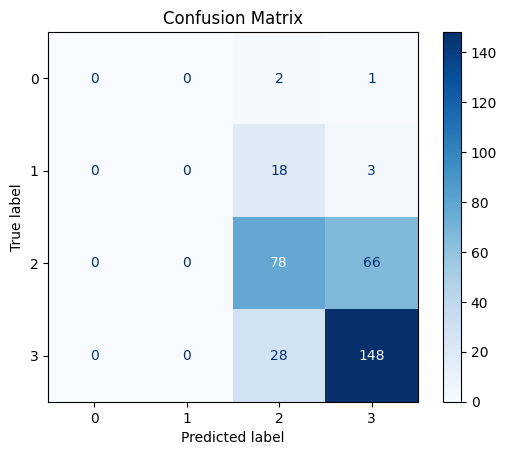

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

I suspect that OrdinalCrossEntropyLoss might be better for this sort of task. We can do:
```python
from torch_ordinal import OrdinalCrossEntropyLoss
loss_fn = OrdinalCrossEntropyLoss(...)
```

Question 3. Use the model you created to run inference on each example of the test dataset and save all predictions in submissions.csv file.

Suggested steps:

- Create one PyTorch DataLoader, test from test.csv
- Load your fine-tuned model for evaluation
- Generate predictions for all datum in test.csv
- Save results in submissions.csv in format defined above.



In [ ]:
# load model from disk
model = BertForSequenceClassification.from_pretrained(
    "bert_tiny_finetuned", local_files_only=True, num_labels=5
)

In [ ]:
def predict(model, test_loader) -> List[int]:
    """
    Run inference on a test dataset using the trained model.

    Args:
        model (Module). The fine-tuned model for classification.
        test_loader (DataLoader): DataLoader containing the test dataset.

    Returns:
        List[int]: A list of predicted class labels in the range [1,5]
    """

    predictions = []

    # do not store gradients during prediction
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]

            outputs = model(input_ids, attention_mask=attention_mask)
            # remap predictions to [1..5] (before it was [0..4])
            preds = torch.argmax(outputs.logits, dim=1).numpy() + 1
            # could potentially do this more efficiently.
            for pred in preds.tolist():
                predictions.append(pred)

    return predictions

In [ ]:
# switch to eval mode
model.eval()

# initialise the train dataset
test_df = pd.read_csv("data/test.csv")
test_dataset = EssayDataset(test_df, tokeniser, target_label=None)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# make predictions on test set
test_predictions = predict(model, test_loader)

In [ ]:
# now save predictions to submissions.csv in the appropriate format

test_df = pd.read_csv("data/test.csv")

test_df["score"] = test_predictions
test_df[["content", "score"]].to_csv("data/submissions.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np

try:
    actual_file = "./data/sample-submissions.csv"
    pred_file = "./data/submissions.csv"

    actual_data = pd.read_csv(actual_file)
    actuals = np.array(actual_data["score"].tolist()[:10])

    pred_data = pd.read_csv(pred_file)
    preds = np.array(pred_data["score"].tolist()[:10])

    metric = 1 - np.mean(np.abs(actuals - preds) / actuals)

    if metric < 0 or metric > 1:
        metric = 0

    print(f"Format valid, FS_SCORE:{metric * 100} %")
except Exception as e:
    print("Format invalid: ", e)